## Introduction
This notebook is based off this [tutorial](https://chanzuckerberg.github.io/cellxgene-census/notebooks/api_demo/census_embedding_search.html?utm_content=303437580&utm_medium=social&utm_source=linkedin&hss_channel=lcp-11301003) fron [CellXGene](https://chanzuckerberg.github.io/cellxgene-census/)


Using the ```cellxgene_census``` package we will search Census embeddings to find cells that are similar to a query cell. I found out I had a vCPU limit on the the types of instances I could launch on AWS EC2, I ran this notebook on my local machine with the the good ol' [PMBC3k](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) dataset.  

The high level overview is that the code will generate [scVI embeddings](https://docs.scvi-tools.org/en/1.0.0/tutorials/notebooks/api_overview.html) of the query cells (the PBMCs) and search the Census scVI embeddings for the most similar cells.




## Downloading data and Census scVI model

Let's import the necessary libraries and download the data and the Census scVI model.

In [1]:
! pip install --upgrade  'cellxgene_census[experimental]' scvi-tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.9/387.9 kB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 10.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.4/786.4 kB 22.4 MB/s eta 0:00:0000:01
  Attempting uninstall: scvi-tools
    Found existing installation: scvi-tools 1.1.5
    Uninstalling scvi-tools-1.1.5:
      Successfully uninstalled scvi-tools-1.1.5


In [3]:
import warnings

warnings.filterwarnings("ignore")

import anndata
import cellxgene_census.experimental
import cellxgene_census
import pandas as pd
import scanpy as sc
import scvi

CENSUS_VERSION = "2024-07-01"

In [2]:
!mkdir -p data
!wget --no-check-certificate -q -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
!tar -xzf data/pbmc3k_filtered_gene_bc_matrices.tar.gz -C data/

Next download the Census embeddings model by first identiying the S3 URI.

In [4]:
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    census = cellxgene_census.open_soma(census_version=CENSUS_VERSION)

    scvi_info = cellxgene_census.experimental.get_embedding_metadata_by_name(
        embedding_name="scvi",
        organism="homo_sapiens",
        census_version=CENSUS_VERSION,
    )

scvi_info["model_link"]

's3://cellxgene-contrib-public/models/scvi/2024-07-01/homo_sapiens/model.pt'

In [4]:
!mkdir -p scvi-human-2024-07-01
!wget --no-check-certificate -q -O scvi-human-2024-07-01/model.pt https://cellxgene-contrib-public.s3.us-west-2.amazonaws.com/models/scvi/2024-07-01/homo_sapiens/model.pt

## Make an AnnData of the PBMC3k dataset

In [6]:
adata = sc.read_10x_mtx("data/filtered_gene_bc_matrices/hg19/", var_names="gene_ids")
adata.var["ensembl_id"] = adata.var.index
adata.obs["n_counts"] = adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))
adata.obs["batch"] = "unassigned"

#lets do some basic filtering


sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)



Next, run the data through the scVI model and extract the cell embeddings.These cells are are our query cells. 

In [7]:
scvi.model.SCVI.prepare_query_anndata(adata, "scvi-human-2024-07-01")
vae_q = scvi.model.SCVI.load_query_data(
    adata,
    "scvi-human-2024-07-01",
)

# This allows for a simple forward pass
vae_q.is_trained = True
latent = vae_q.get_latent_representation()
adata.obsm["scvi"] = latent #these are the embeddings

INFO     File scvi-human-2024-07-01/model.pt already downloaded                                                    
INFO     Found 22.4625% reference vars in query data.                                                              
INFO     File scvi-human-2024-07-01/model.pt already downloaded                                                    


In [8]:
# filter out missing features
adata = adata[:, adata.var["gene_symbols"].notnull().values].copy()
adata.var.set_index("gene_symbols", inplace=True)
# assign placeholder cell_type and tissue_general labels
adata.var_names = adata.var["ensembl_id"]
adata.obs["cell_type"] = "Query - PBMC 10X"
adata.obs["tissue_general"] = "Query - PBMC 10X"

## Compute Leiden clusters on the scVI embeddings

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


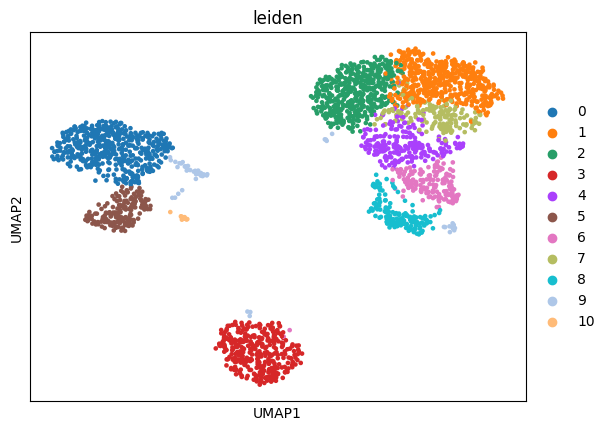

In [9]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="scvi")
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color="leiden")

## Search the Census embeddings for similar cells

Finally, we will search the Census embeddings for the most similar cells to the query cells.



In [10]:
%%time
neighbors = cellxgene_census.experimental.find_nearest_obs(
    "scvi", "homo_sapiens", CENSUS_VERSION, query=adata, k=30, memory_GiB=8, nprobe=20
)

CPU times: user 2min 58s, sys: 2min 2s, total: 5min 1s
Wall time: 10min 15s


The scvi embeddings of the query cells were searched against the Census embeddings to find the most similar cells in Euclidean distance. The distances and soma_join ids are returned in neighbors. 

In [11]:
neighbors

NeighborObs(distances=array([[0.14981087, 0.15093209, 0.24764827, ..., 0.31863752, 0.31922767,
        0.32021427],
       [0.29017177, 0.32429656, 0.3460446 , ..., 0.56234473, 0.56352055,
        0.5670927 ],
       [0.40463755, 0.41439012, 0.41772968, ..., 0.55779386, 0.56181395,
        0.56271565],
       ...,
       [0.19712518, 0.25228167, 0.27800363, ..., 0.3479049 , 0.34811276,
        0.3518863 ],
       [0.36992392, 0.38329887, 0.39696068, ..., 0.56015193, 0.56454164,
        0.56465834],
       [0.33078685, 0.3308514 , 0.35727897, ..., 0.5287459 , 0.5310724 ,
        0.53260446]], dtype=float32), neighbor_ids=array([[53938900, 56894874, 53976967, ..., 35410014, 53999332, 53010089],
       [ 6276632, 18807209,  7251536, ..., 12705987, 11951694, 11980870],
       [16903285, 21674180, 50898826, ..., 35424173, 44145922, 36066801],
       ...,
       [36336282, 52999747, 53523979, ..., 54143971, 53062159, 46403244],
       [36217923, 46782331, 35719817, ..., 54091908, 46313955, 4

Next, make an AnnData object of the each query cell's single nearest neightbor in scVI space. 



In [12]:
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    neighbors_adata = cellxgene_census.get_anndata(
        census,
        "homo_sapiens",
        "RNA",
        obs_coords=sorted(neighbors.neighbor_ids[:, 0].tolist()),
        obs_embeddings=["scvi"],
        X_name="normalized",
        column_names={"obs": ["soma_joinid", "tissue", "tissue_general", "cell_type"]},
    )
neighbors_adata.var_names = neighbors_adata.var["feature_id"]

Make a UMAP of the single nearest neighbors in scVI space.

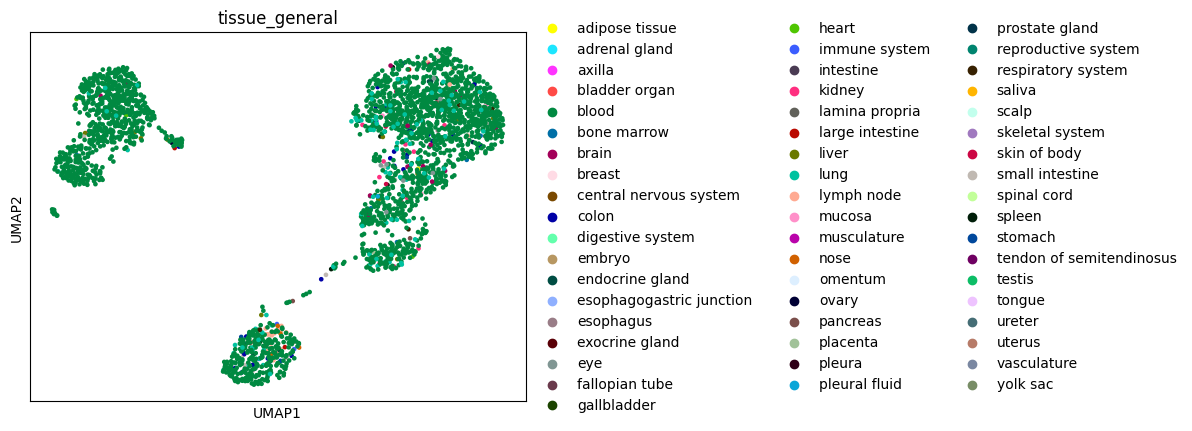

In [13]:
sc.pp.neighbors(neighbors_adata, n_neighbors=15, use_rep="scvi")
sc.tl.umap(neighbors_adata)
sc.pl.umap(neighbors_adata, color="tissue_general")

Not suprisingly, the single nearest neighbors in scVI space are very similar to the query cells with the same general tissue type (blood).

Next, concat the query cells with the single nearest neighbors in scVI space and make a UMAP of the combined cells.

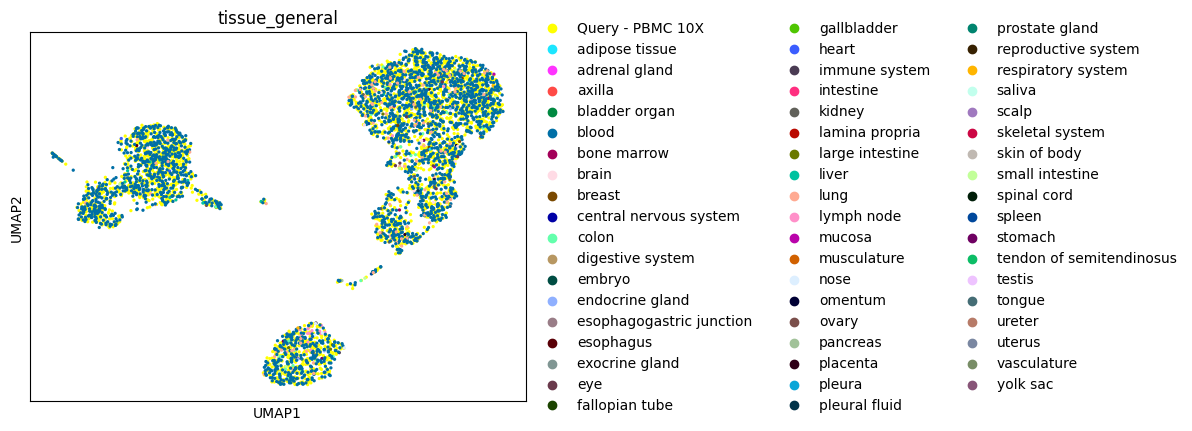

In [14]:
adata_concat = anndata.concat([adata, neighbors_adata])
sc.pp.neighbors(adata_concat, n_neighbors=15, use_rep="scvi")
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=["tissue_general"])

## Predicting cell metadata

The experimental API has a method to predict metadata features of the query cells, like ```tissue_general``` and ```cell_type``` based on the Census neighbors.

In [16]:
predictions = cellxgene_census.experimental.predict_obs_metadata(
    "homo_sapiens", CENSUS_VERSION, neighbors, ["tissue_general", "cell_type"]
)
predictions

,tissue_general,tissue_general_confidence,cell_type,cell_type_confidence
0,blood,0.833333,"CD4-positive, alpha-beta T cell",0.366667
1,lymph node,0.366667,B cell,0.433333
2,blood,0.966667,"central memory CD4-positive, alpha-beta T cell",0.266667
3,blood,0.900000,classical monocyte,0.733333
4,blood,0.900000,natural killer cell,0.633333
...,...,...,...,...
2695,blood,0.800000,classical monocyte,0.600000
2696,immune system,0.366667,plasmablast,0.566667
2697,blood,0.966667,B cell,0.633333
2698,blood,0.866667,B cell,0.600000


Note, that the code above uses all the ```k=30``` neighbors to predict the metadata features of the query cells, unlike the previous code that only used the single nearest neighbor when making the visualization.

In [17]:
adata

AnnData object with n_obs × n_vars = 2700 × 1797
    obs: 'n_counts', 'joinid', 'batch', 'n_genes', '_scvi_batch', '_scvi_labels', 'cell_type', 'tissue_general', 'leiden'
    var: 'ensembl_id', 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'scvi', 'X_umap'
    obsp: 'distances', 'connectivities'

Let's add these predictions to the orginal query cells AnnData object and make a UMAP of the predicted cell type

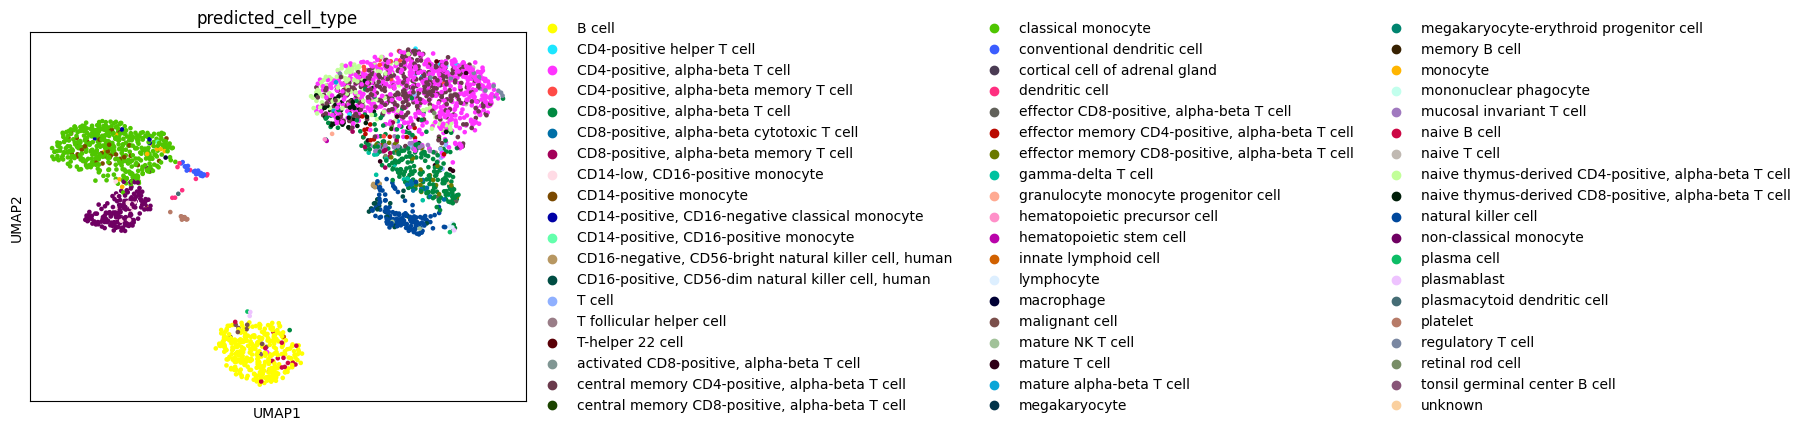

In [18]:
predictions.index = adata.obs.index
predictions = predictions.rename(columns={"cell_type": "predicted_cell_type"})
adata.obs = pd.concat([adata.obs, predictions], axis=1)

sc.pl.umap(adata, color="predicted_cell_type")


Next, let's annotate the Leiden clusters calculated at the beginning step by popular vote, where each cluster gets annotated with the most common predicted cell type.



In [19]:
adata.obs["predicted_consolidated_cell_type"] = ""
for leiden_cluster in adata.obs["leiden"].drop_duplicates():
    most_popular_type = (
        adata.obs.loc[adata.obs["leiden"] == leiden_cluster,].value_counts("predicted_cell_type").index[0]
    )
    adata.obs.loc[adata.obs["leiden"] == leiden_cluster, "predicted_consolidated_cell_type"] = most_popular_type

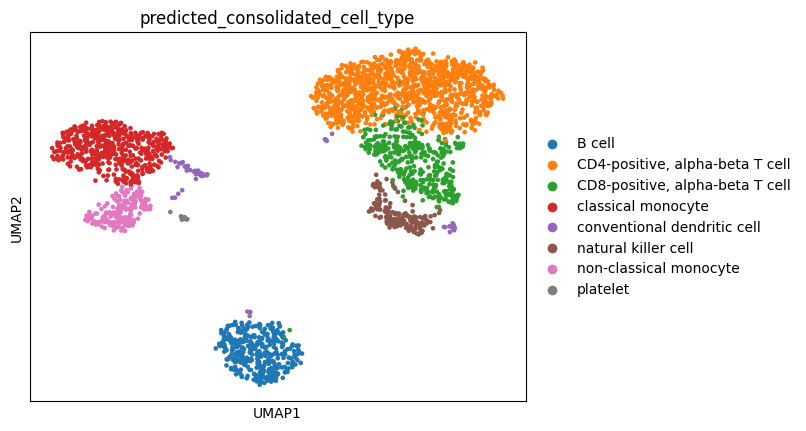

In [20]:
sc.pl.umap(adata, color="predicted_consolidated_cell_type")
